In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras import models, layers


In [2]:
IMG_SIZE= 256
BATCH_SIZE=32


In [3]:
df= tf.keras.preprocessing.image_dataset_from_directory(
      "PlantVillage1", shuffle=True, image_size=(IMG_SIZE, IMG_SIZE),
       batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names= df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

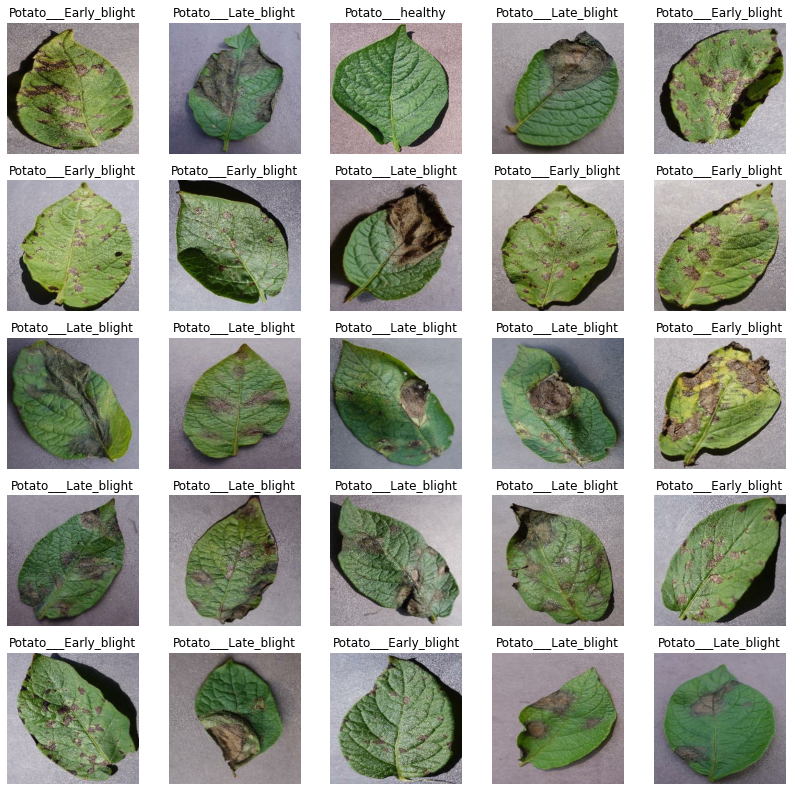

In [5]:
plt.figure(figsize=(14,14))
for image_batch,labels_batch in df.take(1):
    for i in range(25):
        ax=plt.subplot(5 ,5, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
def train_test_val_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(df)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=10)
    train_size=int(train_split* ds_size)
    val_size= int(val_split* ds_size)
    train_ds= ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds= train_test_val_split(df)

In [8]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

54
8
6


In [9]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resizing_rescaling= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [11]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3)
])

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
input_shape=(BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)
num_classes=3
model = models.Sequential([
    resizing_rescaling,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
EPOCHS=48
history=model.fit(
      train_ds,
      batch_size=BATCH_SIZE,
      validation_data=val_ds,
      verbose=1,
      epochs=EPOCHS
)

Epoch 1/48
54/54 [==============================] - 134s 2s/step - loss: 0.9217 - accuracy: 0.4900 - val_loss: 0.8700 - val_accuracy: 0.5000
Epoch 2/48
54/54 [==============================] - 125s 2s/step - loss: 0.7014 - accuracy: 0.6919 - val_loss: 0.6477 - val_accuracy: 0.7344
Epoch 3/48
54/54 [==============================] - 125s 2s/step - loss: 0.4154 - accuracy: 0.8345 - val_loss: 0.4660 - val_accuracy: 0.8438
Epoch 4/48
54/54 [==============================] - 122s 2s/step - loss: 0.3182 - accuracy: 0.8744 - val_loss: 0.3589 - val_accuracy: 0.8594
Epoch 5/48
54/54 [==============================] - 121s 2s/step - loss: 0.2431 - accuracy: 0.9067 - val_loss: 0.3115 - val_accuracy: 0.8802
Epoch 6/48
54/54 [==============================] - 123s 2s/step - loss: 0.1985 - accuracy: 0.9237 - val_loss: 0.3088 - val_accuracy: 0.8594
Epoch 7/48
54/54 [==============================] - 118s 2s/step - loss: 0.1769 - accuracy: 0.9313 - val_loss: 0.2072 - val_accuracy: 0.9115
Epoch 8/48
54

In [19]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 3s 203ms/step - loss: 0.0245 - accuracy: 0.9844


In [20]:
scores

[0.024458423256874084, 0.984375]

In [22]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']



Text(0.5, 1.0, 'Training and Validation Loss')

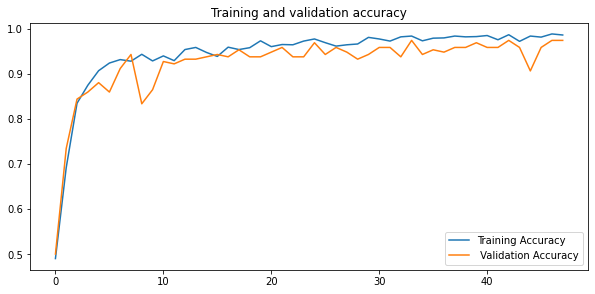

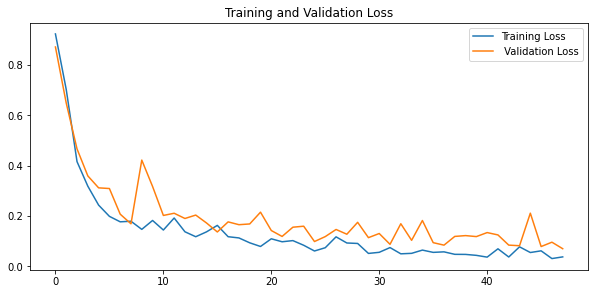

In [31]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label=' Validation Accuracy')
plt.legend(loc="lower right")
plt.title('Training and validation accuracy')

plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label=' Validation Loss')
plt.legend(loc="upper right")
plt.title('Training and Validation Loss')


Actual label of the first image: Potato___Late_blight
1/1 [==============================] - 1s 598ms/step
Predicted Label:  Potato___Late_blight


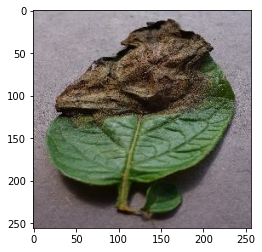

In [38]:
for images_batch, labels_batch in test_ds.take(1):
    first_img= images_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0].numpy()
    plt.imshow(first_img)
    print("Actual label of the first image:", class_names[first_label])
    
    batch_prediction= model.predict(images_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [49]:
def predict(model, img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array= tf.expand_dims(img_array, 0)
    predictions= model.predict(img_array)
    predicted_class= class_names[np.argmax(predictions[0])]
    confidence= round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 60ms/step


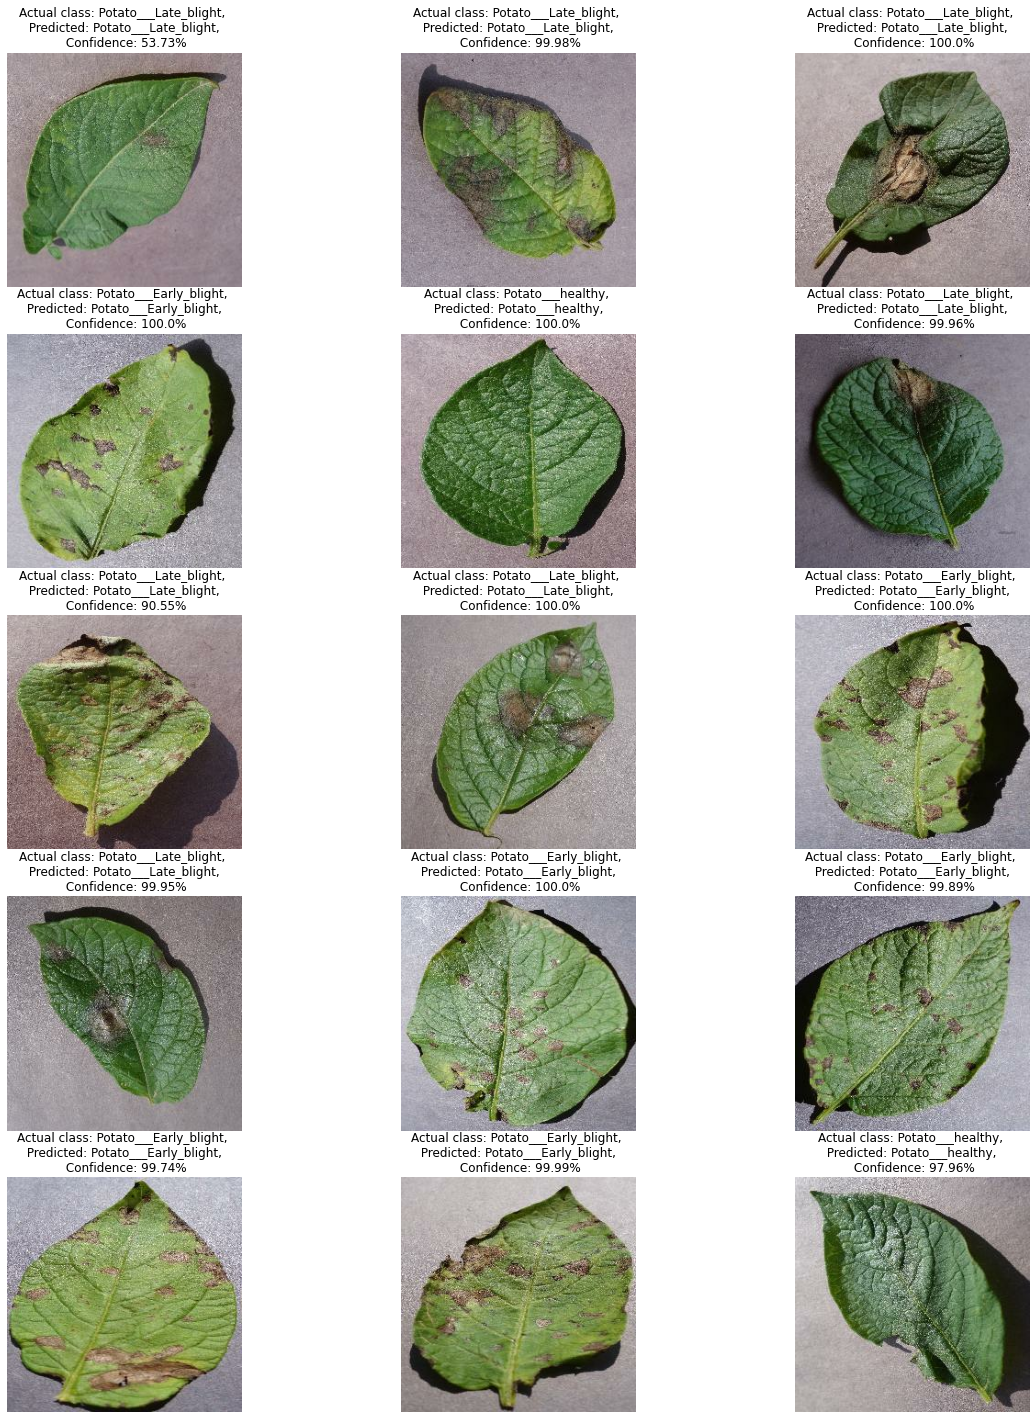

In [57]:
plt.figure(figsize=(20,25))
for images, labels in test_ds.take(1):
    for i in range(15):
        ax=plt.subplot(5,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence=predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual class: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")
        

In [59]:
model_version=1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
